In [1]:
import os
import sys

import pandas as pd

sys.path.append(os.path.abspath(".."))

from models.xgboost import (create_model, evaluate_model,
                            get_autocorrelation_lags, train_model)
from utils.plotting import plot_train_val, plot_usage
from utils.preprocess import (create_features_and_targets, encode_categoricals,
                              split_train_val)

True


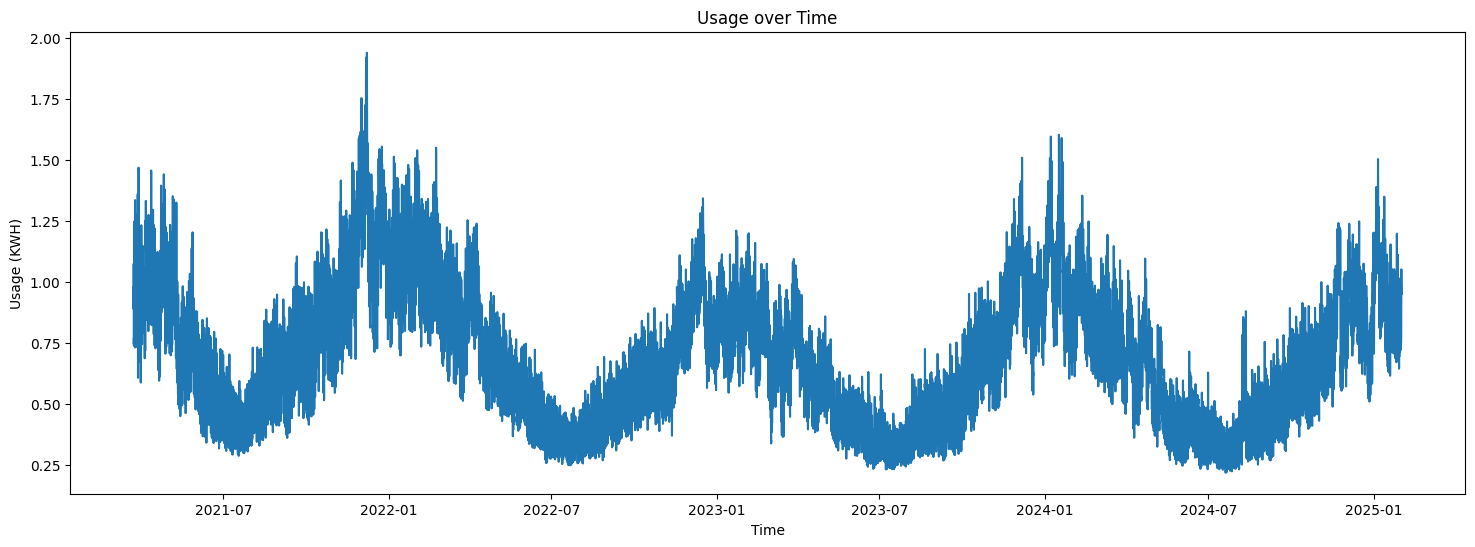

In [2]:
df = pd.read_csv('../data/consumption/dataset.csv')

df['USAGE_AT'] = pd.to_datetime(df['USAGE_AT'])
df['diff'] = df['USAGE_AT'].diff()

# Exclude the first row (where .diff() is NaT)
df_valid = df[df['diff'].notna()]

# Now check if all differences are exactly 1 hour
all_hourly = (df_valid['diff'] == pd.Timedelta(hours=1)).all()
df = df.drop(columns='diff')
print(all_hourly)

plot_usage(df)

In [3]:
df

,USAGE_AT,MONTH,DAY_OF_MONTH,WEEKDAY,HOUR,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m,USAGE_KWH
0,2021-03-23 00:00:00+00:00,3,23,1,0,2.6,0.0,0.0,0.0,7.1,0.976258
1,2021-03-23 01:00:00+00:00,3,23,1,1,2.6,0.0,0.0,0.0,7.1,0.964150
2,2021-03-23 02:00:00+00:00,3,23,1,2,2.5,0.0,0.0,0.0,7.2,0.953400
3,2021-03-23 03:00:00+00:00,3,23,1,3,2.4,0.0,0.0,0.0,7.2,0.889413
4,2021-03-23 04:00:00+00:00,3,23,1,4,2.3,0.0,0.0,0.0,7.6,0.908430
...,...,...,...,...,...,...,...,...,...,...,...
33860,2025-01-31 20:00:00+00:00,1,31,4,20,0.7,0.0,0.0,0.0,13.3,0.985828
33861,2025-01-31 21:00:00+00:00,1,31,4,21,0.3,0.0,0.0,0.0,14.4,0.993425
33862,2025-01-31 22:00:00+00:00,1,31,4,22,-0.0,0.0,0.0,0.0,14.4,0.987878
33863,2025-01-31 23:00:00+00:00,1,31,4,23,-0.2,0.0,0.0,0.0,14.8,0.969646


In [4]:
df = encode_categoricals(df)

df

,USAGE_AT,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,USAGE_KWH
0,2021-03-23 00:00:00+00:00,2.6,0.0,0.0,0.0,7.1,0.000000,1.000000,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.976258
1,2021-03-23 01:00:00+00:00,2.6,0.0,0.0,0.0,7.1,0.258819,0.965926,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.964150
2,2021-03-23 02:00:00+00:00,2.5,0.0,0.0,0.0,7.2,0.500000,0.866025,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.953400
3,2021-03-23 03:00:00+00:00,2.4,0.0,0.0,0.0,7.2,0.707107,0.707107,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.889413
4,2021-03-23 04:00:00+00:00,2.3,0.0,0.0,0.0,7.6,0.866025,0.500000,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.908430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33860,2025-01-31 20:00:00+00:00,0.7,0.0,0.0,0.0,13.3,-0.866025,0.500000,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.985828
33861,2025-01-31 21:00:00+00:00,0.3,0.0,0.0,0.0,14.4,-0.707107,0.707107,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.993425
33862,2025-01-31 22:00:00+00:00,-0.0,0.0,0.0,0.0,14.4,-0.500000,0.866025,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.987878
33863,2025-01-31 23:00:00+00:00,-0.2,0.0,0.0,0.0,14.8,-0.258819,0.965926,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.969646


In [5]:
autocorr_indexes = get_autocorrelation_lags(df)

Top 3 lags:
[[24, 0.9484993950877721], [25, 0.9365858629443371], [48, 0.9110621409077085]]


In [6]:
X, y, feature_names = create_features_and_targets(df, forecast_horizon=24, lags=autocorr_indexes, return_feature_names=True)

print(X.shape, y.shape)

feature_names

(33793, 16) (33793,)


['temperature_2m',
 'precipitation',
 'direct_radiation',
 'uv_index',
 'wind_speed_10m',
 'hour_sin',
 'hour_cos',
 'weekday_sin',
 'weekday_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'lag_24',
 'lag_25',
 'lag_48']

In [7]:
scale_columns = ["temperature_2m", "precipitation", "direct_radiation", "uv_index", "wind_speed_10m", "lag_24", "lag_25", "lag_48"]

In [8]:
train_split = 0.9
scaler_type = 'minmax'

X_train, y_train, X_val, y_val, scaler_x, scaler_y = split_train_val(X, y, feature_names, train_split, scaler_type, scale_columns=scale_columns, device=None)

Applying minmax scaling.
X_train shape: (30413, 16)
y_train shape: (30413, 1)
X_val shape: (3380, 16)
y_val shape: (3380, 1)


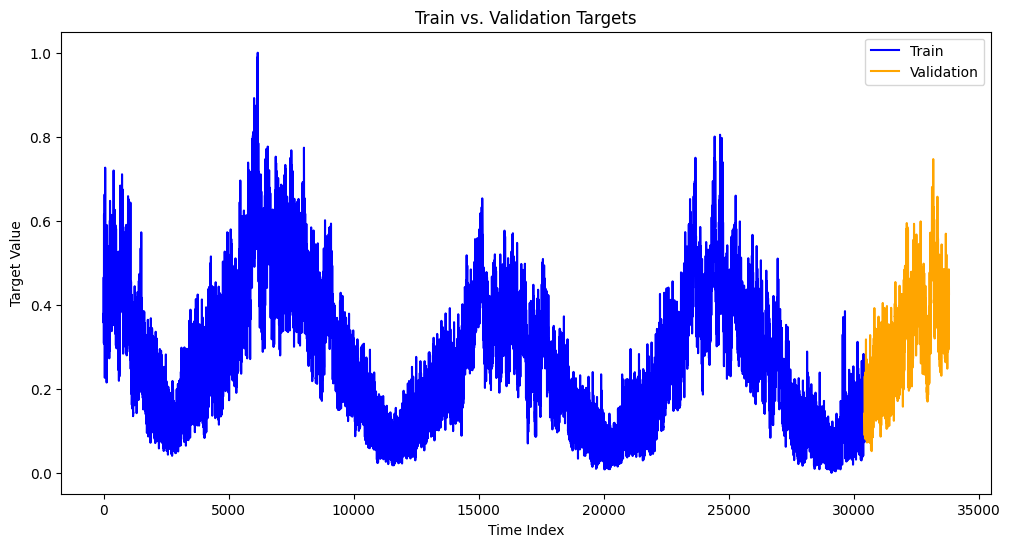

In [9]:
plot_train_val(y_train, y_val)

In [10]:
n_estimators = 10000
lr = 0.05
random_state = 42

model = create_model(n_estimators, lr, random_state)

model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
trained_model = train_model(model, X_train, y_train)

MAE: 0.0718
MAPE: 9.62%
RMSE: 0.0973
kWh actual: 2545.224125707411, kWh pred: 2549.5615234375, diff (%): 0.170413194118353


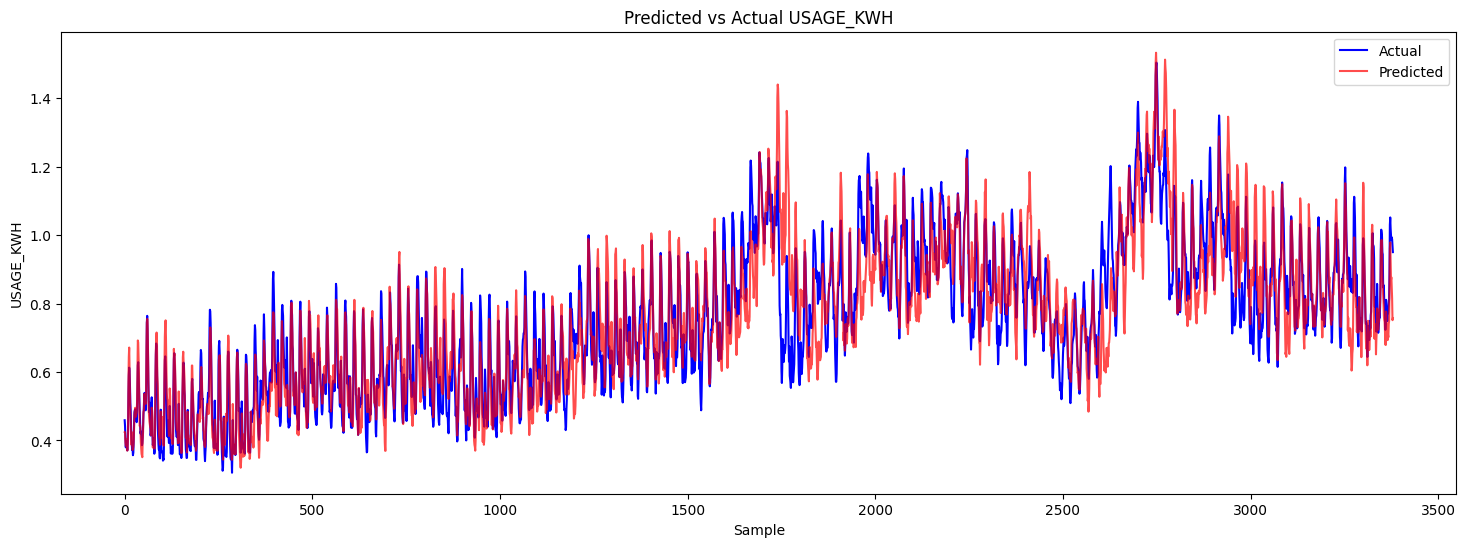

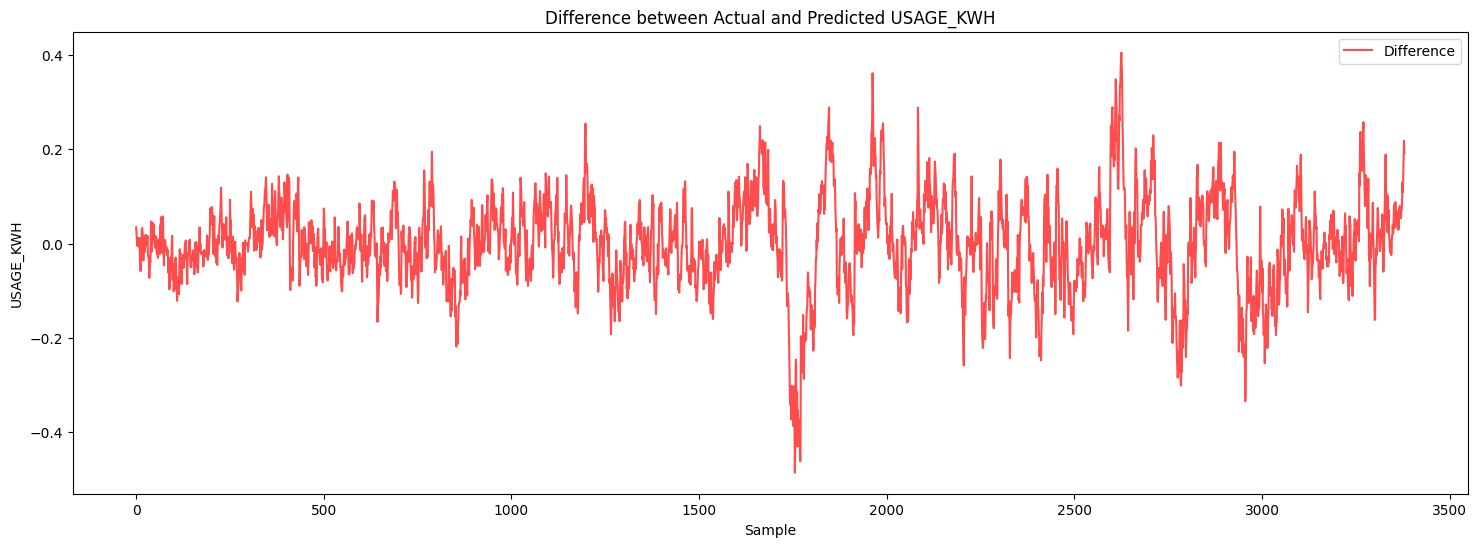

In [12]:
_ = evaluate_model(trained_model, X_val, y_val, scaler_y)